In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

sys.path.append(r"C:\Users\BBA\Coding\Resources")
import btk
import dataset_generators as dgen

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
plt.style.use(r'C:\Users\BBA\.matplotlib\styles\standard.mplstyle')


In [2]:
trainx, trainy, valx, valy = btk.depickler('trainx-1639302881', 'trainy-1639302881', 'valx-1639302881', 'valy-1639302881')
""" trainx, trainy = dgen.gen_chars(262150, dgen.chars1, dgen.trainfonts, True)
valx, valy = dgen.gen_chars(87400, dgen.chars1, dgen.evalfonts)
num = btk.pickle_set(trainx, trainy, valx, valy)
num """

' trainx, trainy = dgen.gen_chars(262150, dgen.chars1, dgen.trainfonts, True)\nvalx, valy = dgen.gen_chars(87400, dgen.chars1, dgen.evalfonts)\nnum = btk.pickle_set(trainx, trainy, valx, valy)\nnum '

In [ ]:
tx, ty = dgen.gen_chars(15, dgen.chars1, dgen.trainfonts, True)
for x in range(0, 15):
    display(Image.fromarray(tx[x]).convert('RGB'))
    #display(ty[x])

Epoch 1/62
32/32 [==============================] - 9s 88ms/step - loss: 3.9520 - accuracy: 0.0222 - val_loss: 3.9172 - val_accuracy: 0.0260
Epoch 2/62
32/32 [==============================] - 2s 68ms/step - loss: 3.9163 - accuracy: 0.0281 - val_loss: 3.8998 - val_accuracy: 0.0231
Epoch 3/62
32/32 [==============================] - 2s 74ms/step - loss: 3.9055 - accuracy: 0.0303 - val_loss: 3.8956 - val_accuracy: 0.0201
Epoch 4/62
32/32 [==============================] - 2s 76ms/step - loss: 3.8721 - accuracy: 0.0281 - val_loss: 3.7862 - val_accuracy: 0.0387
Epoch 5/62
32/32 [==============================] - 2s 68ms/step - loss: 3.7700 - accuracy: 0.0386 - val_loss: 3.4590 - val_accuracy: 0.0558
Epoch 6/62
32/32 [==============================] - 2s 68ms/step - loss: 3.6159 - accuracy: 0.0576 - val_loss: 3.1208 - val_accuracy: 0.1205
Epoch 7/62
32/32 [==============================] - 2s 68ms/step - loss: 3.4312 - accuracy: 0.0879 - val_loss: 2.8142 - val_accuracy: 0.1704
Epoch 8/62
32

<AxesSubplot:>

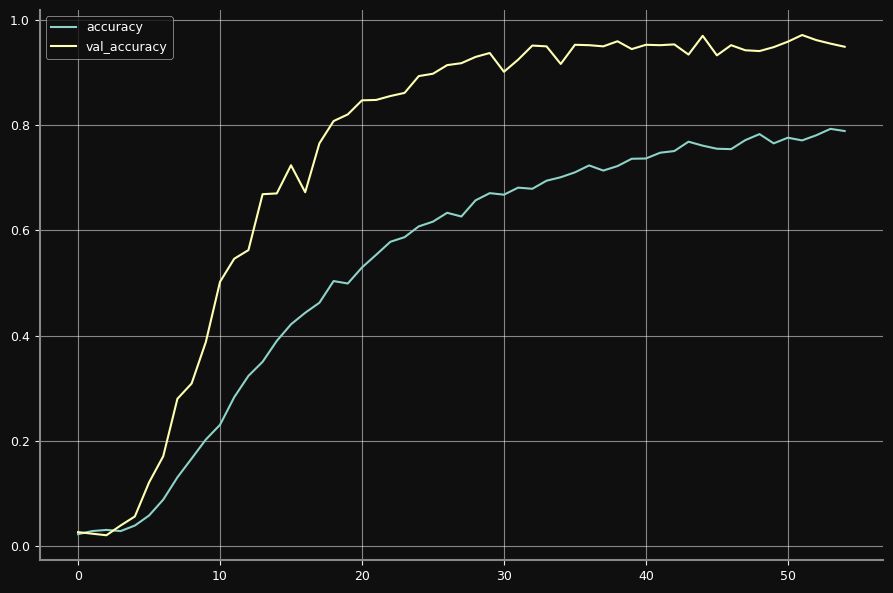

In [3]:
#Character Classifier with CNN

imgent = btk.DataGen(trainx, trainy, 128)
imgenv = btk.DataGen(valx, valy, 42)

inlay = keras.Input(shape=(64, 64, 1))
x = layers.Rescaling(1.0/255)(inlay)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.16)(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.16)(x)
x = layers.Dense(256, activation='relu')(x)
outlay = layers.Dense(52, activation='softmax')(x)

char_classifier = keras.Model(inlay, outlay, name='text_id')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.002, patience=10, restore_best_weights=True)
char_classifier.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = char_classifier.fit(
    x = imgent,
    validation_data=imgenv,
    epochs=62,
    steps_per_epoch=32,
    validation_steps=32,
    callbacks=early_stopping,
    verbose=1
)

hist = pd.DataFrame(history.history)
hist[['accuracy', 'val_accuracy']].plot()

In [16]:
char_classifier.summary()
char_classifier.save('cclass')

Model: "text_id"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 64)        18496     
                                                           

'6x4&x@?;g@ykqn7duqbefwsn'

'6x4&x@?;g@ykqn7duqbefwsn'

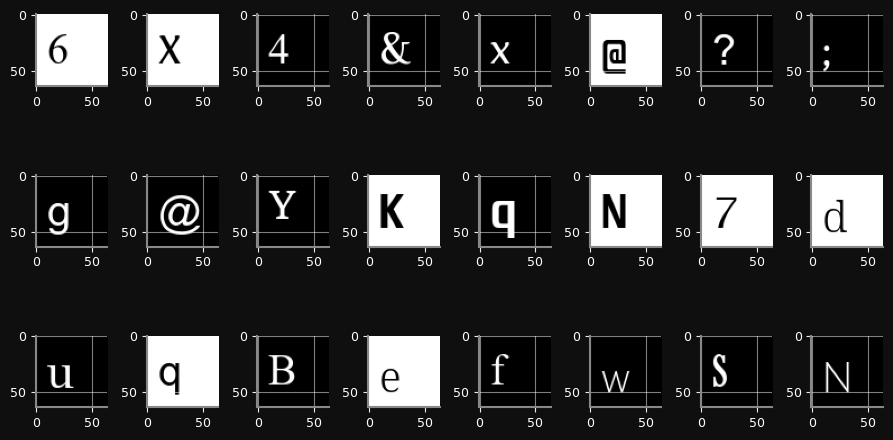

In [4]:
#Character classifier evaluators CNN
char_class_mdl = tf.keras.models.load_model('cclass')

lowers = dgen.chars1.copy()
for x in dgen.string.ascii_uppercase: lowers.remove(x)

pdx, pdy = dgen.gen_chars(24, dgen.chars1, dgen.evalfonts)

answers = [lowers[pdy[x].argmax()] for x in range(0, 24)]
display(''.join(answers))
guesses = [lowers[char_class_mdl.predict(pdx)[x].argmax()] for x in range(0, 24)]
display(''.join(guesses))

for x in range(0, 24):
    plt.subplot(3,8,x+1)
    im = np.array(pdx[x], dtype=float).reshape((64, 64))
    plt.imshow(im, cmap='gray')

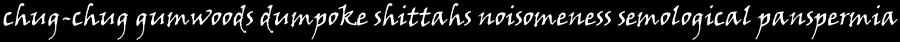

[132, 256, 371, 474, 614, 753]

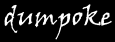

In [123]:
#test = dgen.sentence_slicer(dgen.rand_sentence_img(7, dgen.trainfonts))
display(Image.fromarray(test))
display(dgen.word_sep_check(test, dgen.word_sep(test)))
display(Image.fromarray(test[:, 256:371]))

In [ ]:
""" tst1, tst2 = rand_char_img(chars)
display(tst1)
tst1 = np.array(tst1, dtype=np.float32)
tst1 = tf.expand_dims(tst1,0) """

image = tf.io.read_file(r'C:\Users\BBA\Coding\POE\TradeBot\Data\CVImgs\Tester.png')
image = tf.io.decode_jpeg(image)
image = tf.image.rgb_to_grayscale(image)
image = tf.cast(image, tf.float32)
image0 = tf.expand_dims(image,0)
k1 = tf.constant(np.true_divide([[0, 0, 0, 5, 0, 0, 0], [0, 5, 18, 32, 18, 5, 0], [0, 18, 64, 100, 64, 18, 0], [5, 32, 100, 100, 100, 32, 5], [0, 18, 64, 100, 64, 18, 0], [0, 5, 18, 32, 18, 5, 0], [0, 0, 0, 5, 0, 0, 0]], 256))
k1 = tf.cast(tf.reshape(k1, [*k1.shape, 1, 1]), dtype=tf.float32)
k2 = tf.constant([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
k2 = tf.cast(tf.reshape(k2, [*k2.shape, 1, 1]), dtype=tf.float32)

image1 = tf.nn.conv2d(
    input=image0,
    filters=k1,
    strides=1,
    padding='SAME'
)
image2 = tf.nn.relu(image1)
image3 = tf.nn.pool(
    input=image2,
    window_shape=(2, 2),
    pooling_type='MAX',
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(12, 6))
plt.imshow(tf.squeeze(image2))
plt.axis('off')
plt.show()